# Final Project - Linden Beemer
### Bioinformatics - Fall 2022

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import linear, relu, sigmoid
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

## Problem Description
For this project, I have decided to study a dataset that classifies blood donors vs individuals with Hepatitis C, including the Hepatitis C progress. I want to see if I can create a neural network algorithm that accurately classifies this data as it is given. This data comes from researchers at Trillium GmbH, the Helmholtz Centre for Infection Reasearch, and the Institute of Clinical Chemistry at Medical University Hannover, all based in Germany. There are 615 instances of data and 14 attributes of data including the diagnosis.

## Biomedical Dataset and Preprocessing
The dataset chosen comes from hcvdat0.csv and includes the following attributes:

    -- 1. patient id    (int)
    -- 2. category      (string), (the predicted attribute)
    -- 3. age           (int)
    -- 4. sex           (char)
    -- 5. ALB           (float)
    -- 6. ALP           (float)
    -- 7. ALT           (float)
    -- 8. AST           (float)
    -- 9. BIL           (float)
    -- 10. CHE          (float)
    -- 11. CHOL         (float)
    -- 12. CREA         (float)
    -- 13. GGT          (float)
    -- 14. PROT         (float)
    
For the purpose of the model, I will ommit the first attribute (patient id) as well as normalize the category and sex attributes into integers. The sex attribute marks data as either *f* or *m*. I simplify these to 0 and 1, respectively. The category attribute marks data as *'0=Blood Donor', '0s=suspect Blood Donor', '1=Hepatitis', '2=Fibrosis', '3=Cirrhosis.'* I will simplify these to the numbers mentioned, and I will include the 0s data as if they were blood donors to increase data available.

The dataset does also include missing data denoted as *'NA'*. In order to correct this I adapt my preprocess_data() method from HW7 to replace the missing data with the average value of that row.

In [3]:
def preprocess_Xdata(X):
    '''
    Proprocess the data so that the missing item is replaced by the average value of each attribute (i.e., each column)
    Also swaps 'f' and 'm' to num values.
    Args:
        X : (ndarray Shape(m,n)) data with string type
        
    Return: 
        X : (ndarray Shape(m,n)) data with float type - the missing element has been replaced by 
        the average value of each attribute
    '''
    ### START CODE HERE ### 
    m, n = X.shape
    na_mark = []
    
    ## convert everything to doubles and save locations of ?
    for i in range(m):
        for j in range(n):
            if X[i][j] == "NA":
                na_mark.append((i, j))
            elif X[i][j] == '"f"':
                X[i][j] = 0.0
            elif X[i][j] == '"m"':
                X[i][j] = 1.0
            else:
                X[i][j] = X[i][j].astype(np.float32) 
    
    for k in range(len(na_mark)):
        na_counter = 0
        na_sum = 0
        curr_na = na_mark[k]
        curr = X[:, curr_na[1]]
        length = curr.shape[0]
        for l in range(length): 
            if curr[l] == "NA":
                na_counter += 1
            else:
                na_sum += float(curr[l])
        X[curr_na[0]][curr_na[1]] = na_sum / (length - na_counter)
        
    X = X.astype(np.float32)    
    for i in range(m):
        for j in range(n):
            if isinstance(X[i][j], str):
                print("string found at: ", i, j)
        
    
    return X
    ### END CODE HERE ###   

In [4]:
def preprocess_ydata(y):
    '''
    Proprocess y data to seperate out 0s data and convert to numerical data
    Args:
        y : (ndarray Shape(N,)) data with string type
        
    Return: 
        y : (ndarray Shape(N,)) data with converted float type
    '''
    n = y.shape[0]
    
    for i in range(n):
        if y[i] == '"0=Blood Donor"' or y[i] == '"0s=suspect Blood Donor"':
            y[i] = 0.0
        elif y[i] == '"1=Hepatitis"':
            y[i] = 1.0
        elif y[i] == '"2=Fibrosis"':
            y[i] = 2.0
        else:
            y[i] = 3.0
    
    y = y.astype(np.float32)
    
    return y

In [5]:
# load dataset

def load_data(filename):
    ### START CODE HERE ### 
    data = np.genfromtxt(filename, delimiter=",", dtype=str)
    X_all = data[1:, 2:]
    y_all = data[1:, 1]
    X_all = preprocess_Xdata(X_all)
    y_all = preprocess_ydata(y_all)
    
    ### END CODE HERE ### 

    return X_all, y_all

In [6]:
X, y = load_data("data/hcvdat0.csv")
print("first elem in X: ", X[0])
print("first elem in y: : ", y[0])

first elem in X:  [ 32.     1.    38.5   52.5    7.7   22.1    7.5    6.93   3.23 106.
  12.1   69.  ]
first elem in y: :  0.0


## Model Selection and Implementation
Here, I construct 3 models of varying complexity to see how they fit my data. I generate one "simple" model featuring only two levels, a RELU and a linear activation with 5 units each. I also generate an intermediate model with two RELU layers and a linear layer, with 50, 15, and 5 layers respectively. Finally, I construct a complex model with the same layers as the intermediate one, but with 100, 30, and 10 layers respectively. Those models are constructed below.

In [7]:
tf.random.set_seed(1234)
model_1 = Sequential(
    [      
        tf.keras.Input(shape=(12,)),
        tf.keras.layers.Dense(units=5, activation="relu"),
        tf.keras.layers.Dense(units=5, activation="linear")
    ], name = "model_1" 
)

In [8]:
tf.random.set_seed(1234)
model_2 = Sequential(
    [      
        tf.keras.Input(shape=(12,)),
        tf.keras.layers.Dense(units=25, activation="relu"),
        tf.keras.layers.Dense(units=15, activation="relu"),
        tf.keras.layers.Dense(units=5, activation="linear")
    ], name = "model_2" 
)

In [9]:
tf.random.set_seed(1234)
model_3 = Sequential(
    [      
        tf.keras.Input(shape=(12,)),
        tf.keras.layers.Dense(units=100, activation="relu"),
        tf.keras.layers.Dense(units=30, activation="relu"),
        tf.keras.layers.Dense(units=10, activation="linear")
    ], name = "model_3" 
)

In [10]:
model_1.summary()
model_2.summary()
model_3.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 65        
                                                                 
 dense_1 (Dense)             (None, 5)                 30        
                                                                 
Total params: 95
Trainable params: 95
Non-trainable params: 0
_________________________________________________________________
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 25)                325       
                                                                 
 dense_3 (Dense)             (None, 15)                390       
                                                                 
 dense_4 (Dense)             (None, 5)        

My next step after compiling these models is to split my data into training, cross validation, and test sets. I will then compile my models. All of my models will use SparseCategoricalCrossentropy and an Adam optimizer with learning rate of 0.001.  

In [40]:
X_train, X_, y_train, y_ = train_test_split(X,y,test_size=0.50, random_state=1)
X_cv, X_test, y_cv, y_test = train_test_split(X_,y_,test_size=0.20, random_state=1)
print("X_train.shape:", X_train.shape, "X_cv.shape:", X_cv.shape, "X_test.shape:", X_test.shape)
print("y_train.shape:", y_train.shape, "y_cv.shape:", y_cv.shape, "y_test.shape:", y_test.shape)

X_train.shape: (307, 12) X_cv.shape: (246, 12) X_test.shape: (62, 12)
y_train.shape: (307,) y_cv.shape: (246,) y_test.shape: (62,)


In [12]:
model_1.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
)

history = model_1.fit(          
    X_train, y_train,
    epochs=1000
)
hist_1 = history.history['loss']

Epoch 1/1000
10/10 [==============================] - 0s 1ms/step - loss: 10.2614
Epoch 2/1000
10/10 [==============================] - 0s 2ms/step - loss: 8.6215
Epoch 3/1000
10/10 [==============================] - 0s 2ms/step - loss: 7.6029
Epoch 4/1000
10/10 [==============================] - 0s 2ms/step - loss: 6.9006
Epoch 5/1000
10/10 [==============================] - 0s 1ms/step - loss: 6.4504
Epoch 6/1000
10/10 [==============================] - 0s 2ms/step - loss: 5.9776
Epoch 7/1000
10/10 [==============================] - 0s 2ms/step - loss: 5.6532
Epoch 8/1000
10/10 [==============================] - 0s 3ms/step - loss: 5.2857
Epoch 9/1000
10/10 [==============================] - 0s 2ms/step - loss: 5.0278
Epoch 10/1000
10/10 [==============================] - 0s 2ms/step - loss: 4.7521
Epoch 11/1000
10/10 [==============================] - 0s 1ms/step - loss: 4.5167
Epoch 12/1000
10/10 [==============================] - 0s 1ms/step - loss: 4.3141
Epoch 13/1000
10/10 [===

Epoch 101/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.6613
Epoch 102/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.6545
Epoch 103/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.6479
Epoch 104/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.6401
Epoch 105/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.6338
Epoch 106/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.6278
Epoch 107/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.6243
Epoch 108/1000
10/10 [==============================] - 0s 886us/step - loss: 0.6252
Epoch 109/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.6160
Epoch 110/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.6142
Epoch 111/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.6084
Epoch 112/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.6069
Ep

10/10 [==============================] - 0s 2ms/step - loss: 0.4628
Epoch 200/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.4647
Epoch 201/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.4633
Epoch 202/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.4615
Epoch 203/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.4623
Epoch 204/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.4658
Epoch 205/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.4578
Epoch 206/1000
10/10 [==============================] - 0s 877us/step - loss: 0.4576
Epoch 207/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.4569
Epoch 208/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.4556
Epoch 209/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.4559
Epoch 210/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.4571
Epoch 211/1000
10

10/10 [==============================] - 0s 1ms/step - loss: 0.3892
Epoch 298/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.3891
Epoch 299/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.3879
Epoch 300/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.3884
Epoch 301/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.3855
Epoch 302/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.3847
Epoch 303/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.3832
Epoch 304/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.3830
Epoch 305/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.3811
Epoch 306/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.3810
Epoch 307/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.3792
Epoch 308/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.3788
Epoch 309/1000
10/1

10/10 [==============================] - 0s 1ms/step - loss: 0.2842
Epoch 396/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.2834
Epoch 397/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.2828
Epoch 398/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.2818
Epoch 399/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.2812
Epoch 400/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.2800
Epoch 401/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.2794
Epoch 402/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.2789
Epoch 403/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.2779
Epoch 404/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.2774
Epoch 405/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.2765
Epoch 406/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.2761
Epoch 407/1000
10/1

10/10 [==============================] - 0s 2ms/step - loss: 0.2323
Epoch 494/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.2321
Epoch 495/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.2321
Epoch 496/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.2321
Epoch 497/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.2316
Epoch 498/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.2314
Epoch 499/1000
10/10 [==============================] - 0s 3ms/step - loss: 0.2312
Epoch 500/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.2306
Epoch 501/1000
10/10 [==============================] - 0s 3ms/step - loss: 0.2306
Epoch 502/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.2306
Epoch 503/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.2300
Epoch 504/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.2297
Epoch 505/1000
10/1

10/10 [==============================] - 0s 2ms/step - loss: 0.2123
Epoch 592/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.2123
Epoch 593/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.2121
Epoch 594/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.2120
Epoch 595/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.2120
Epoch 596/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.2124
Epoch 597/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.2118
Epoch 598/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.2118
Epoch 599/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.2117
Epoch 600/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.2115
Epoch 601/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.2119
Epoch 602/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.2109
Epoch 603/1000
10/1

10/10 [==============================] - 0s 2ms/step - loss: 0.2056
Epoch 690/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.2051
Epoch 691/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.2049
Epoch 692/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.2049
Epoch 693/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.2047
Epoch 694/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.2051
Epoch 695/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.2050
Epoch 696/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.2054
Epoch 697/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.2048
Epoch 698/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.2048
Epoch 699/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.2051
Epoch 700/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.2049
Epoch 701/1000
10/1

10/10 [==============================] - 0s 1ms/step - loss: 0.2022
Epoch 788/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.2020
Epoch 789/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.2033
Epoch 790/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.2021
Epoch 791/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.2018
Epoch 792/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.2018
Epoch 793/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.2018
Epoch 794/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.2014
Epoch 795/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.2017
Epoch 796/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.2014
Epoch 797/1000
10/10 [==============================] - 0s 980us/step - loss: 0.2013
Epoch 798/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.2016
Epoch 799/1000
10

10/10 [==============================] - 0s 1ms/step - loss: 0.2009
Epoch 886/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.2003
Epoch 887/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.2002
Epoch 888/1000
10/10 [==============================] - 0s 992us/step - loss: 0.2002
Epoch 889/1000
10/10 [==============================] - 0s 870us/step - loss: 0.1999
Epoch 890/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.2003
Epoch 891/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.2005
Epoch 892/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.2001
Epoch 893/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.2000
Epoch 894/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.2000
Epoch 895/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.2001
Epoch 896/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.1996
Epoch 897/1000


10/10 [==============================] - 0s 2ms/step - loss: 0.1995
Epoch 984/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.1989
Epoch 985/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.1989
Epoch 986/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.1987
Epoch 987/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.1987
Epoch 988/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.1990
Epoch 989/1000
10/10 [==============================] - 0s 905us/step - loss: 0.1989
Epoch 990/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.1986
Epoch 991/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1990
Epoch 992/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.1991
Epoch 993/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1991
Epoch 994/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.1987
Epoch 995/1000
10

In [13]:
model_2.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
)

history = model_2.fit(          
    X_train, y_train,
    epochs=1000
)
hist_2 = history.history['loss']

Epoch 1/1000
10/10 [==============================] - 0s 1ms/step - loss: 9.7356
Epoch 2/1000
10/10 [==============================] - 0s 2ms/step - loss: 4.9400
Epoch 3/1000
10/10 [==============================] - 0s 2ms/step - loss: 4.4263
Epoch 4/1000
10/10 [==============================] - 0s 2ms/step - loss: 3.6762
Epoch 5/1000
10/10 [==============================] - 0s 2ms/step - loss: 3.1504
Epoch 6/1000
10/10 [==============================] - 0s 2ms/step - loss: 2.5479
Epoch 7/1000
10/10 [==============================] - 0s 2ms/step - loss: 2.1120
Epoch 8/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.6288
Epoch 9/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.2703
Epoch 10/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.9451
Epoch 11/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.7069
Epoch 12/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.5602
Epoch 13/1000
10/10 [====

10/10 [==============================] - 0s 1ms/step - loss: 0.0664
Epoch 102/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.0661
Epoch 103/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.0644
Epoch 104/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.0631
Epoch 105/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.0615
Epoch 106/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.0619
Epoch 107/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.0637
Epoch 108/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.0638
Epoch 109/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.0611
Epoch 110/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.0648
Epoch 111/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.0573
Epoch 112/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.0573
Epoch 113/1000
10/1

10/10 [==============================] - 0s 2ms/step - loss: 0.0296
Epoch 200/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.0279
Epoch 201/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.0295
Epoch 202/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.0312
Epoch 203/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.0289
Epoch 204/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.0268
Epoch 205/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.0267
Epoch 206/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.0256
Epoch 207/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.0260
Epoch 208/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.0255
Epoch 209/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.0252
Epoch 210/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.0246
Epoch 211/1000
10/1

10/10 [==============================] - 0s 2ms/step - loss: 0.0145
Epoch 298/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.0151
Epoch 299/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.0150
Epoch 300/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.0146
Epoch 301/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.0146
Epoch 302/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.0143
Epoch 303/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.0133
Epoch 304/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.0137
Epoch 305/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.0134
Epoch 306/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.0128
Epoch 307/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.0165
Epoch 308/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.0173
Epoch 309/1000
10/1

10/10 [==============================] - 0s 2ms/step - loss: 0.0068
Epoch 396/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.0077
Epoch 397/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.0073
Epoch 398/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.0073
Epoch 399/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.0071
Epoch 400/1000
10/10 [==============================] - 0s 3ms/step - loss: 0.0067
Epoch 401/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.0067
Epoch 402/1000
10/10 [==============================] - 0s 3ms/step - loss: 0.0072
Epoch 403/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.0061
Epoch 404/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.0068
Epoch 405/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.0067
Epoch 406/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.0065
Epoch 407/1000
10/1

10/10 [==============================] - 0s 2ms/step - loss: 0.0028
Epoch 494/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.0028
Epoch 495/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.0027
Epoch 496/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.0029
Epoch 497/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.0025
Epoch 498/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.0027
Epoch 499/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.0028
Epoch 500/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.0024
Epoch 501/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.0029
Epoch 502/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.0025
Epoch 503/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.0025
Epoch 504/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.0025
Epoch 505/1000
10/1

10/10 [==============================] - 0s 1ms/step - loss: 0.0014
Epoch 592/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 593/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 594/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 595/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 596/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 597/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 598/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.0012
Epoch 599/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.0012
Epoch 600/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 601/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 602/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 603/1000
10/1

10/10 [==============================] - 0s 2ms/step - loss: 7.1319e-04
Epoch 688/1000
10/10 [==============================] - 0s 2ms/step - loss: 6.3501e-04
Epoch 689/1000
10/10 [==============================] - 0s 1ms/step - loss: 6.4844e-04
Epoch 690/1000
10/10 [==============================] - 0s 1ms/step - loss: 6.6226e-04
Epoch 691/1000
10/10 [==============================] - 0s 1ms/step - loss: 6.1710e-04
Epoch 692/1000
10/10 [==============================] - 0s 1ms/step - loss: 6.2140e-04
Epoch 693/1000
10/10 [==============================] - 0s 2ms/step - loss: 6.1403e-04
Epoch 694/1000
10/10 [==============================] - 0s 1ms/step - loss: 5.9314e-04
Epoch 695/1000
10/10 [==============================] - 0s 2ms/step - loss: 5.9270e-04
Epoch 696/1000
10/10 [==============================] - 0s 2ms/step - loss: 5.8286e-04
Epoch 697/1000
10/10 [==============================] - 0s 2ms/step - loss: 6.2745e-04
Epoch 698/1000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 1ms/step - loss: 3.3375e-04
Epoch 782/1000
10/10 [==============================] - 0s 1ms/step - loss: 3.4534e-04
Epoch 783/1000
10/10 [==============================] - 0s 1ms/step - loss: 3.5117e-04
Epoch 784/1000
10/10 [==============================] - 0s 1ms/step - loss: 3.6992e-04
Epoch 785/1000
10/10 [==============================] - 0s 1ms/step - loss: 4.0084e-04
Epoch 786/1000
10/10 [==============================] - 0s 1ms/step - loss: 3.4224e-04
Epoch 787/1000
10/10 [==============================] - 0s 1ms/step - loss: 3.3737e-04
Epoch 788/1000
10/10 [==============================] - 0s 1ms/step - loss: 3.1008e-04
Epoch 789/1000
10/10 [==============================] - 0s 1ms/step - loss: 3.2196e-04
Epoch 790/1000
10/10 [==============================] - 0s 2ms/step - loss: 3.2294e-04
Epoch 791/1000
10/10 [==============================] - 0s 1ms/step - loss: 3.3533e-04
Epoch 792/1000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 2ms/step - loss: 1.9086e-04
Epoch 876/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.7778e-04
Epoch 877/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.8229e-04
Epoch 878/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.8939e-04
Epoch 879/1000
10/10 [==============================] - 0s 2ms/step - loss: 2.0350e-04
Epoch 880/1000
10/10 [==============================] - 0s 1ms/step - loss: 1.8517e-04
Epoch 881/1000
10/10 [==============================] - 0s 1ms/step - loss: 1.8581e-04
Epoch 882/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.6833e-04
Epoch 883/1000
10/10 [==============================] - 0s 1ms/step - loss: 1.7490e-04
Epoch 884/1000
10/10 [==============================] - 0s 1ms/step - loss: 1.7018e-04
Epoch 885/1000
10/10 [==============================] - 0s 1ms/step - loss: 1.8050e-04
Epoch 886/1000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 1ms/step - loss: 1.1690e-04
Epoch 970/1000
10/10 [==============================] - 0s 1ms/step - loss: 1.0394e-04
Epoch 971/1000
10/10 [==============================] - 0s 1ms/step - loss: 1.0357e-04
Epoch 972/1000
10/10 [==============================] - 0s 1ms/step - loss: 1.1294e-04
Epoch 973/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.0157e-04
Epoch 974/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.0243e-04
Epoch 975/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.0131e-04
Epoch 976/1000
10/10 [==============================] - 0s 2ms/step - loss: 9.6832e-05
Epoch 977/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.0242e-04
Epoch 978/1000
10/10 [==============================] - 0s 2ms/step - loss: 9.8409e-05
Epoch 979/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.0659e-04
Epoch 980/1000
10/10 [==============================] - 0s

In [14]:
model_3.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
)

history = model_3.fit(          
    X_train, y_train,
    epochs=1000
)
hist_3 = history.history['loss']

Epoch 1/1000
10/10 [==============================] - 0s 2ms/step - loss: 15.2091
Epoch 2/1000
10/10 [==============================] - 0s 2ms/step - loss: 2.4374
Epoch 3/1000
10/10 [==============================] - 0s 1ms/step - loss: 1.5539
Epoch 4/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.9323
Epoch 5/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.5975
Epoch 6/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.4781
Epoch 7/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.3714
Epoch 8/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.3423
Epoch 9/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.3222
Epoch 10/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.2351
Epoch 11/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.2045
Epoch 12/1000
10/10 [==============================] - 0s 3ms/step - loss: 0.1813
Epoch 13/1000
10/10 [===

Epoch 101/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.0453
Epoch 102/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.0453
Epoch 103/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.0293
Epoch 104/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.0270
Epoch 105/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.0219
Epoch 106/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.0202
Epoch 107/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.0183
Epoch 108/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.0212
Epoch 109/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.0210
Epoch 110/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.0251
Epoch 111/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.0232
Epoch 112/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.0287
Epoc

10/10 [==============================] - 0s 1ms/step - loss: 0.0044
Epoch 200/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.0046
Epoch 201/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.0052
Epoch 202/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.0047
Epoch 203/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.0046
Epoch 204/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.0043
Epoch 205/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.0041
Epoch 206/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.0060
Epoch 207/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.0060
Epoch 208/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.0070
Epoch 209/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.0064
Epoch 210/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.0047
Epoch 211/1000
10/1

10/10 [==============================] - 0s 3ms/step - loss: 0.0017
Epoch 298/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.0016
Epoch 299/1000
10/10 [==============================] - 0s 3ms/step - loss: 0.0017
Epoch 300/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.0016
Epoch 301/1000
10/10 [==============================] - 0s 3ms/step - loss: 0.0015
Epoch 302/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.0017
Epoch 303/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.0015
Epoch 304/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.0015
Epoch 305/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.0015
Epoch 306/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.0016
Epoch 307/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.0021
Epoch 308/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.0023
Epoch 309/1000
10/1

10/10 [==============================] - 0s 1ms/step - loss: 7.8040e-04
Epoch 396/1000
10/10 [==============================] - 0s 1ms/step - loss: 8.1895e-04
Epoch 397/1000
10/10 [==============================] - 0s 2ms/step - loss: 8.0845e-04
Epoch 398/1000
10/10 [==============================] - 0s 2ms/step - loss: 7.3542e-04
Epoch 399/1000
10/10 [==============================] - 0s 2ms/step - loss: 7.4456e-04
Epoch 400/1000
10/10 [==============================] - 0s 2ms/step - loss: 7.2029e-04
Epoch 401/1000
10/10 [==============================] - 0s 2ms/step - loss: 7.6553e-04
Epoch 402/1000
10/10 [==============================] - 0s 2ms/step - loss: 7.2878e-04
Epoch 403/1000
10/10 [==============================] - 0s 2ms/step - loss: 7.1069e-04
Epoch 404/1000
10/10 [==============================] - 0s 2ms/step - loss: 7.1320e-04
Epoch 405/1000
10/10 [==============================] - 0s 2ms/step - loss: 7.3962e-04
Epoch 406/1000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 2ms/step - loss: 3.9765e-04
Epoch 490/1000
10/10 [==============================] - 0s 2ms/step - loss: 3.8601e-04
Epoch 491/1000
10/10 [==============================] - 0s 2ms/step - loss: 3.8466e-04
Epoch 492/1000
10/10 [==============================] - 0s 2ms/step - loss: 3.8377e-04
Epoch 493/1000
10/10 [==============================] - 0s 2ms/step - loss: 3.8584e-04
Epoch 494/1000
10/10 [==============================] - 0s 2ms/step - loss: 3.8270e-04
Epoch 495/1000
10/10 [==============================] - 0s 2ms/step - loss: 3.8307e-04
Epoch 496/1000
10/10 [==============================] - 0s 2ms/step - loss: 3.8234e-04
Epoch 497/1000
10/10 [==============================] - 0s 2ms/step - loss: 3.7161e-04
Epoch 498/1000
10/10 [==============================] - 0s 3ms/step - loss: 3.7001e-04
Epoch 499/1000
10/10 [==============================] - 0s 2ms/step - loss: 3.6923e-04
Epoch 500/1000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 2ms/step - loss: 2.4297e-04
Epoch 584/1000
10/10 [==============================] - 0s 1ms/step - loss: 2.2838e-04
Epoch 585/1000
10/10 [==============================] - 0s 2ms/step - loss: 2.4197e-04
Epoch 586/1000
10/10 [==============================] - 0s 2ms/step - loss: 2.2606e-04
Epoch 587/1000
10/10 [==============================] - 0s 2ms/step - loss: 2.4349e-04
Epoch 588/1000
10/10 [==============================] - 0s 2ms/step - loss: 2.2359e-04
Epoch 589/1000
10/10 [==============================] - 0s 1ms/step - loss: 2.4149e-04
Epoch 590/1000
10/10 [==============================] - 0s 1ms/step - loss: 2.2470e-04
Epoch 591/1000
10/10 [==============================] - 0s 1ms/step - loss: 2.1630e-04
Epoch 592/1000
10/10 [==============================] - 0s 1ms/step - loss: 2.1789e-04
Epoch 593/1000
10/10 [==============================] - 0s 1ms/step - loss: 2.1623e-04
Epoch 594/1000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 2ms/step - loss: 1.4126e-04
Epoch 678/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.4697e-04
Epoch 679/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.4394e-04
Epoch 680/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.4840e-04
Epoch 681/1000
10/10 [==============================] - 0s 1ms/step - loss: 1.5127e-04
Epoch 682/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.4195e-04
Epoch 683/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.4271e-04
Epoch 684/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.3323e-04
Epoch 685/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.3467e-04
Epoch 686/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.3461e-04
Epoch 687/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.3267e-04
Epoch 688/1000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 1ms/step - loss: 8.7921e-05
Epoch 772/1000
10/10 [==============================] - 0s 1ms/step - loss: 8.2890e-05
Epoch 773/1000
10/10 [==============================] - 0s 1ms/step - loss: 8.2179e-05
Epoch 774/1000
10/10 [==============================] - 0s 2ms/step - loss: 8.2361e-05
Epoch 775/1000
10/10 [==============================] - 0s 1ms/step - loss: 8.3740e-05
Epoch 776/1000
10/10 [==============================] - 0s 2ms/step - loss: 8.2951e-05
Epoch 777/1000
10/10 [==============================] - 0s 2ms/step - loss: 8.4426e-05
Epoch 778/1000
10/10 [==============================] - 0s 2ms/step - loss: 7.8068e-05
Epoch 779/1000
10/10 [==============================] - 0s 2ms/step - loss: 8.4262e-05
Epoch 780/1000
10/10 [==============================] - 0s 2ms/step - loss: 8.0378e-05
Epoch 781/1000
10/10 [==============================] - 0s 2ms/step - loss: 7.9104e-05
Epoch 782/1000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 2ms/step - loss: 5.3224e-05
Epoch 866/1000
10/10 [==============================] - 0s 2ms/step - loss: 5.3537e-05
Epoch 867/1000
10/10 [==============================] - 0s 2ms/step - loss: 4.9020e-05
Epoch 868/1000
10/10 [==============================] - 0s 1ms/step - loss: 4.9648e-05
Epoch 869/1000
10/10 [==============================] - 0s 1ms/step - loss: 4.8348e-05
Epoch 870/1000
10/10 [==============================] - 0s 2ms/step - loss: 4.8356e-05
Epoch 871/1000
10/10 [==============================] - 0s 2ms/step - loss: 4.9726e-05
Epoch 872/1000
10/10 [==============================] - 0s 2ms/step - loss: 5.0100e-05
Epoch 873/1000
10/10 [==============================] - 0s 2ms/step - loss: 4.7863e-05
Epoch 874/1000
10/10 [==============================] - 0s 2ms/step - loss: 4.6785e-05
Epoch 875/1000
10/10 [==============================] - 0s 2ms/step - loss: 5.0830e-05
Epoch 876/1000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 1ms/step - loss: 3.0393e-05
Epoch 960/1000
10/10 [==============================] - 0s 2ms/step - loss: 3.0515e-05
Epoch 961/1000
10/10 [==============================] - 0s 1ms/step - loss: 3.0224e-05
Epoch 962/1000
10/10 [==============================] - 0s 2ms/step - loss: 3.0323e-05
Epoch 963/1000
10/10 [==============================] - 0s 2ms/step - loss: 2.8823e-05
Epoch 964/1000
10/10 [==============================] - 0s 2ms/step - loss: 2.8747e-05
Epoch 965/1000
10/10 [==============================] - 0s 2ms/step - loss: 2.8408e-05
Epoch 966/1000
10/10 [==============================] - 0s 2ms/step - loss: 3.0512e-05
Epoch 967/1000
10/10 [==============================] - 0s 1ms/step - loss: 2.7769e-05
Epoch 968/1000
10/10 [==============================] - 0s 1ms/step - loss: 2.7971e-05
Epoch 969/1000
10/10 [==============================] - 0s 2ms/step - loss: 2.8164e-05
Epoch 970/1000
10/10 [==============================] - 0s

Below, I graph the loss of each model to visualize the differences between the models.

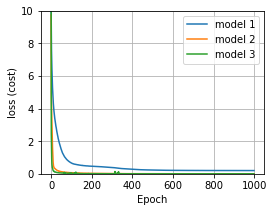

In [15]:
# code to visualize loss of model
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'           # to support higher OS versions 
fig,ax = plt.subplots(1,1, figsize = (4,3))
ax.plot(hist_1, label='model 1')
ax.plot(hist_2, label='model 2')
ax.plot(hist_3, label='model 3')
ax.set_ylim([0, 10])
ax.set_xlabel('Epoch')
ax.set_ylabel('loss (cost)')
ax.legend()
ax.grid(True)
plt.show()

My last step is to use the cross validation data to calculate the error of these three models. I will be using the eval_cat_err() method developed in HW8 for this.

In [16]:
def eval_cat_err(y, yhat):
    """ 
    Calculate the categorization error
    Args:
      y    : (ndarray  Shape (m,) or (m,1))  target value of each example
      yhat : (ndarray  Shape (m,) or (m,1))  predicted value of each example
    Returns:|
      cerr: (scalar)             
    """
    m = len(y)
    incorrect = 0
    for i in range(m):
        if(yhat[i] != y[i]):
            incorrect += 1
    
    cerr = (1 / m) * incorrect
    
    return(cerr)

In [17]:
# create functions to just get output of predict, this is adapted from HW8
model_predict_1 = lambda Xl: np.argmax(tf.nn.softmax(model_1.predict(Xl)).numpy(),axis=1)
model_predict_2 = lambda Xl: np.argmax(tf.nn.softmax(model_2.predict(Xl)).numpy(),axis=1)
model_predict_3 = lambda Xl: np.argmax(tf.nn.softmax(model_3.predict(Xl)).numpy(),axis=1)

# calculate error
training_err_1 = eval_cat_err(y_train, model_predict_1(X_train))
cv_err_1 = eval_cat_err(y_cv, model_predict_1(X_cv))
training_err_2 = eval_cat_err(y_train, model_predict_2(X_train))
cv_err_2 = eval_cat_err(y_cv, model_predict_2(X_cv))
training_err_3 = eval_cat_err(y_train, model_predict_3(X_train))
cv_err_3 = eval_cat_err(y_cv, model_predict_3(X_cv))

# print error
print(f"categorization error, training, model 1: {training_err_1:0.4f}, model 2: {training_err_2:0.4f}, model 3: {training_err_3:0.4f}")
print(f"categorization error, cv,       model 1: {cv_err_1:0.4f}, model 2: {cv_err_2:0.4f}, model 3: {cv_err_3:0.4f}")

8/8 [==============================] - 0s 859us/step
categorization error, training, model 1: 0.0814, model 2: 0.0000, model 3: 0.0000
categorization error, cv,       model 1: 0.1057, model 2: 0.0935, model 3: 0.0935


As you can see, the cross validation error is the same for both model 2 and 3, which is only slightly lower than model 1. For this reason, I will be implemting regularization in models 2 and 3 in the next section.

## Regularization and Parameter Tuning
Below are my adapted models 2 and 3. I begin by adding in the kernal_regularizer from tensorflow to regulize the models and compute the new cost.

In [18]:
tf.random.set_seed(1234)
model_2r = Sequential(
    [      
        tf.keras.Input(shape=(12,)),
        tf.keras.layers.Dense(units=25, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.1)),
        tf.keras.layers.Dense(units=15, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.1)),
        tf.keras.layers.Dense(units=5, activation="linear")
    ], name = "model_2r" 
)
model_2r.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
)

In [19]:
model_2r.fit(
    X_train, y_train,
    epochs=1000
)

Epoch 1/1000
10/10 [==============================] - 0s 2ms/step - loss: 15.2610
Epoch 2/1000
10/10 [==============================] - 0s 2ms/step - loss: 5.7520
Epoch 3/1000
10/10 [==============================] - 0s 2ms/step - loss: 5.0024
Epoch 4/1000
10/10 [==============================] - 0s 3ms/step - loss: 4.6405
Epoch 5/1000
10/10 [==============================] - 0s 2ms/step - loss: 4.3379
Epoch 6/1000
10/10 [==============================] - 0s 3ms/step - loss: 4.0270
Epoch 7/1000
10/10 [==============================] - 0s 2ms/step - loss: 3.7799
Epoch 8/1000
10/10 [==============================] - 0s 3ms/step - loss: 3.5638
Epoch 9/1000
10/10 [==============================] - 0s 2ms/step - loss: 3.3812
Epoch 10/1000
10/10 [==============================] - 0s 2ms/step - loss: 3.2281
Epoch 11/1000
10/10 [==============================] - 0s 3ms/step - loss: 3.0919
Epoch 12/1000
10/10 [==============================] - 0s 2ms/step - loss: 2.9870
Epoch 13/1000
10/10 [===

Epoch 101/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.8784
Epoch 102/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.8724
Epoch 103/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.8654
Epoch 104/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.8585
Epoch 105/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.8516
Epoch 106/1000
10/10 [==============================] - 0s 3ms/step - loss: 0.8437
Epoch 107/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.8398
Epoch 108/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.8378
Epoch 109/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.8262
Epoch 110/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.8207
Epoch 111/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.8108
Epoch 112/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.8047
Epoc

10/10 [==============================] - 0s 1ms/step - loss: 0.4573
Epoch 200/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.4566
Epoch 201/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.4512
Epoch 202/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.4535
Epoch 203/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.4540
Epoch 204/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.4502
Epoch 205/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.4444
Epoch 206/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.4466
Epoch 207/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.4402
Epoch 208/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.4354
Epoch 209/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.4331
Epoch 210/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.4327
Epoch 211/1000
10/1

10/10 [==============================] - 0s 2ms/step - loss: 0.3017
Epoch 298/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.3086
Epoch 299/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.3203
Epoch 300/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.3014
Epoch 301/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.2957
Epoch 302/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.2967
Epoch 303/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.2943
Epoch 304/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.2941
Epoch 305/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.2951
Epoch 306/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.2897
Epoch 307/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.2969
Epoch 308/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.3038
Epoch 309/1000
10/1

10/10 [==============================] - 0s 4ms/step - loss: 0.2345
Epoch 396/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.2320
Epoch 397/1000
10/10 [==============================] - 0s 4ms/step - loss: 0.2239
Epoch 398/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.2315
Epoch 399/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.2227
Epoch 400/1000
10/10 [==============================] - 0s 4ms/step - loss: 0.2231
Epoch 401/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.2214
Epoch 402/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.2207
Epoch 403/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.2194
Epoch 404/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.2226
Epoch 405/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.2195
Epoch 406/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.2212
Epoch 407/1000
10/1

10/10 [==============================] - 0s 2ms/step - loss: 0.1866
Epoch 494/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.1825
Epoch 495/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.1835
Epoch 496/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1861
Epoch 497/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1860
Epoch 498/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1852
Epoch 499/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1841
Epoch 500/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1832
Epoch 501/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1812
Epoch 502/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1852
Epoch 503/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1828
Epoch 504/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1816
Epoch 505/1000
10/1

10/10 [==============================] - 0s 2ms/step - loss: 0.1647
Epoch 592/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.1619
Epoch 593/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.1600
Epoch 594/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1589
Epoch 595/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1623
Epoch 596/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1679
Epoch 597/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1613
Epoch 598/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1612
Epoch 599/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1618
Epoch 600/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.1595
Epoch 601/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.1676
Epoch 602/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1629
Epoch 603/1000
10/1

10/10 [==============================] - 0s 2ms/step - loss: 0.1502
Epoch 690/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1529
Epoch 691/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1550
Epoch 692/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1468
Epoch 693/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1485
Epoch 694/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1516
Epoch 695/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.1568
Epoch 696/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1620
Epoch 697/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1600
Epoch 698/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1525
Epoch 699/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1514
Epoch 700/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.1514
Epoch 701/1000
10/1

10/10 [==============================] - 0s 2ms/step - loss: 0.1569
Epoch 788/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1723
Epoch 789/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.1657
Epoch 790/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1751
Epoch 791/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.1567
Epoch 792/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1461
Epoch 793/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1455
Epoch 794/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1445
Epoch 795/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1443
Epoch 796/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1427
Epoch 797/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1365
Epoch 798/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1436
Epoch 799/1000
10/1

10/10 [==============================] - 0s 2ms/step - loss: 0.1321
Epoch 886/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1335
Epoch 887/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1412
Epoch 888/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1387
Epoch 889/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1406
Epoch 890/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1311
Epoch 891/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1442
Epoch 892/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1411
Epoch 893/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.1387
Epoch 894/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.1303
Epoch 895/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1325
Epoch 896/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1302
Epoch 897/1000
10/1

10/10 [==============================] - 0s 2ms/step - loss: 0.1335
Epoch 984/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1259
Epoch 985/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1274
Epoch 986/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1255
Epoch 987/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.1250
Epoch 988/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1236
Epoch 989/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1350
Epoch 990/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1252
Epoch 991/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1302
Epoch 992/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1285
Epoch 993/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1254
Epoch 994/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1232
Epoch 995/1000
10/1

In [20]:
model_2r.summary()

Model: "model_2r"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 25)                325       
                                                                 
 dense_9 (Dense)             (None, 15)                390       
                                                                 
 dense_10 (Dense)            (None, 5)                 80        
                                                                 
Total params: 795
Trainable params: 795
Non-trainable params: 0
_________________________________________________________________


In [21]:
tf.random.set_seed(1234)
model_3r = Sequential(
    [      
        tf.keras.Input(shape=(12,)),
        tf.keras.layers.Dense(units=100, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.1)),
        tf.keras.layers.Dense(units=30, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.1)),
        tf.keras.layers.Dense(units=10, activation="linear")
    ], name = "model_3r" 
)
model_3r.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
)

In [22]:
model_3r.fit(
    X_train, y_train,
    epochs=1000
)

Epoch 1/1000
10/10 [==============================] - 0s 1ms/step - loss: 17.6443
Epoch 2/1000
10/10 [==============================] - 0s 2ms/step - loss: 10.8385
Epoch 3/1000
10/10 [==============================] - 0s 1ms/step - loss: 8.4423
Epoch 4/1000
10/10 [==============================] - 0s 2ms/step - loss: 7.2574
Epoch 5/1000
10/10 [==============================] - 0s 2ms/step - loss: 6.6798
Epoch 6/1000
10/10 [==============================] - 0s 2ms/step - loss: 6.1749
Epoch 7/1000
10/10 [==============================] - 0s 2ms/step - loss: 5.8068
Epoch 8/1000
10/10 [==============================] - 0s 2ms/step - loss: 5.5301
Epoch 9/1000
10/10 [==============================] - 0s 2ms/step - loss: 5.3027
Epoch 10/1000
10/10 [==============================] - 0s 2ms/step - loss: 5.0936
Epoch 11/1000
10/10 [==============================] - 0s 2ms/step - loss: 4.8253
Epoch 12/1000
10/10 [==============================] - 0s 2ms/step - loss: 4.6508
Epoch 13/1000
10/10 [==

Epoch 101/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1974
Epoch 102/1000
10/10 [==============================] - 0s 1ms/step - loss: 1.1779
Epoch 103/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1719
Epoch 104/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1581
Epoch 105/1000
10/10 [==============================] - 0s 1ms/step - loss: 1.1375
Epoch 106/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1220
Epoch 107/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1111
Epoch 108/1000
10/10 [==============================] - 0s 1ms/step - loss: 1.1141
Epoch 109/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1045
Epoch 110/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.0733
Epoch 111/1000
10/10 [==============================] - 0s 1ms/step - loss: 1.0672
Epoch 112/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.0618
Epoc

10/10 [==============================] - 0s 2ms/step - loss: 0.4442
Epoch 200/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.4438
Epoch 201/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.4371
Epoch 202/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.4328
Epoch 203/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.4303
Epoch 204/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.4334
Epoch 205/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.4251
Epoch 206/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.4258
Epoch 207/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.4181
Epoch 208/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.4101
Epoch 209/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.4073
Epoch 210/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.4015
Epoch 211/1000
10/1

10/10 [==============================] - 0s 2ms/step - loss: 0.2413
Epoch 298/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.2439
Epoch 299/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.2610
Epoch 300/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.2584
Epoch 301/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.2384
Epoch 302/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.2376
Epoch 303/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.2347
Epoch 304/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.2332
Epoch 305/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.2360
Epoch 306/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.2389
Epoch 307/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.2344
Epoch 308/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.2485
Epoch 309/1000
10/1

10/10 [==============================] - 0s 2ms/step - loss: 0.1975
Epoch 396/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1953
Epoch 397/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1854
Epoch 398/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1924
Epoch 399/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1942
Epoch 400/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1903
Epoch 401/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.1848
Epoch 402/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.1865
Epoch 403/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.1830
Epoch 404/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.1874
Epoch 405/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.1845
Epoch 406/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1830
Epoch 407/1000
10/1

10/10 [==============================] - 0s 2ms/step - loss: 0.1707
Epoch 494/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1689
Epoch 495/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1676
Epoch 496/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1698
Epoch 497/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1765
Epoch 498/1000
10/10 [==============================] - 0s 3ms/step - loss: 0.1691
Epoch 499/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1727
Epoch 500/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1709
Epoch 501/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1706
Epoch 502/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1701
Epoch 503/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1671
Epoch 504/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1629
Epoch 505/1000
10/1

10/10 [==============================] - 0s 2ms/step - loss: 0.1543
Epoch 592/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1563
Epoch 593/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1542
Epoch 594/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1507
Epoch 595/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1551
Epoch 596/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.1568
Epoch 597/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1558
Epoch 598/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1524
Epoch 599/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1596
Epoch 600/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1586
Epoch 601/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1537
Epoch 602/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1595
Epoch 603/1000
10/1

10/10 [==============================] - 0s 2ms/step - loss: 0.1445
Epoch 690/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1483
Epoch 691/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1522
Epoch 692/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1423
Epoch 693/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1452
Epoch 694/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1414
Epoch 695/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1436
Epoch 696/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1549
Epoch 697/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1508
Epoch 698/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1477
Epoch 699/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.1424
Epoch 700/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1437
Epoch 701/1000
10/1

10/10 [==============================] - 0s 1ms/step - loss: 0.1462
Epoch 788/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.1453
Epoch 789/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1435
Epoch 790/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1399
Epoch 791/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1416
Epoch 792/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1401
Epoch 793/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1385
Epoch 794/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1339
Epoch 795/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.1361
Epoch 796/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1313
Epoch 797/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1312
Epoch 798/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1376
Epoch 799/1000
10/1

10/10 [==============================] - 0s 2ms/step - loss: 0.1268
Epoch 886/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1236
Epoch 887/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1309
Epoch 888/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1402
Epoch 889/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1344
Epoch 890/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1236
Epoch 891/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1387
Epoch 892/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1383
Epoch 893/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1348
Epoch 894/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1260
Epoch 895/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1243
Epoch 896/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1262
Epoch 897/1000
10/1

10/10 [==============================] - 0s 2ms/step - loss: 0.1323
Epoch 984/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1208
Epoch 985/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1182
Epoch 986/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1165
Epoch 987/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1168
Epoch 988/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1164
Epoch 989/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1221
Epoch 990/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1211
Epoch 991/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1200
Epoch 992/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1245
Epoch 993/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1237
Epoch 994/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1189
Epoch 995/1000
10/1

In [23]:
model_3r.summary()

Model: "model_3r"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 100)               1300      
                                                                 
 dense_12 (Dense)            (None, 30)                3030      
                                                                 
 dense_13 (Dense)            (None, 10)                310       
                                                                 
Total params: 4,640
Trainable params: 4,640
Non-trainable params: 0
_________________________________________________________________


In [24]:
# create functions to just get output of predict
model_predict_2r = lambda Xl: np.argmax(tf.nn.softmax(model_2r.predict(Xl)).numpy(),axis=1)
model_predict_3r = lambda Xl: np.argmax(tf.nn.softmax(model_3r.predict(Xl)).numpy(),axis=1)

# calculate error
training_err_2r = eval_cat_err(y_train, model_predict_2r(X_train))
cv_err_2r = eval_cat_err(y_cv, model_predict_2r(X_cv))
training_err_3r = eval_cat_err(y_train, model_predict_3r(X_train))
cv_err_3r = eval_cat_err(y_cv, model_predict_3r(X_cv))

# print error
print(f"categorization error, training, model 2r: {training_err_2r:0.4f}, model 3r: {training_err_3r:0.4f}")
print(f"categorization error, training, model 2:  {training_err_2:0.4f}, model 3:  {training_err_3:0.4f}")
print(f"categorization error, cv,       model 2r: {cv_err_2r:0.4f}, model 3r: {cv_err_3r:0.4f}")
print(f"categorization error, cv,       model 2:  {cv_err_2:0.4f}, model 3:  {cv_err_3:0.4f}")

8/8 [==============================] - 0s 1ms/step
categorization error, training, model 2r: 0.0163, model 3r: 0.0163
categorization error, training, model 2:  0.0000, model 3:  0.0000
categorization error, cv,       model 2r: 0.0894, model 3r: 0.0935
categorization error, cv,       model 2:  0.0935, model 3:  0.0935


As you can see, although the error has increased for all of the regularized models, it has resulted in a difference between model 2 and 3. In addition, this is also where I adjusted my epochs amount from 100 to 1000 on all of my models. This did effect the error on all of my models.

## Evaluation
For evaluation, I am suspecting that I have a skew in my data, largely due to the fact that there are so many more blood donor examples in this dataset compared to Hepatitis examples. For this reason, I am going to evaluate the precision and recall in order to find the F1-score. I will be using tools from the sklearn library for this section, and I will compute precision, recall, and F-1 scores before displaying it in a table for evaluation.

In [25]:
from sklearn.metrics import precision_score

# create the predictions needed for these scores
y_1 = model_predict_1(X_test)
y_2 = model_predict_2(X_test)
y_3 = model_predict_3(X_test)
y_2r = model_predict_2r(X_test)
y_3r = model_predict_3r(X_test)

# generate precision scores
prec_1 = precision_score(y_test, y_1, average='macro', zero_division=0)
prec_2 = precision_score(y_test, y_2, average='macro', zero_division=0)
prec_3 = precision_score(y_test, y_3, average='macro', zero_division=0)
prec_2r = precision_score(y_test, y_2r, average='macro', zero_division=0)
prec_3r = precision_score(y_test, y_3r, average='macro', zero_division=0)

2/2 [==============================] - 0s 1ms/step


In [26]:
from sklearn.metrics import recall_score

# generate recall scores
rec_1 = recall_score(y_test, y_1, average='macro', zero_division=0)
rec_2 = recall_score(y_test, y_2, average='macro', zero_division=0)
rec_3 = recall_score(y_test, y_3, average='macro', zero_division=0)
rec_2r = recall_score(y_test, y_2r, average='macro', zero_division=0)
rec_3r = recall_score(y_test, y_3r, average='macro', zero_division=0)

In [27]:
# calculate F-1 scores
f1_1 = 2 * (prec_1 * rec_1) / (prec_1 + rec_1)
f1_2 = 2 * (prec_2 * rec_2) / (prec_2 + rec_2)
f1_3 = 2 * (prec_3 * rec_3) / (prec_3 + rec_3)
f1_2r = 2 * (prec_2r * rec_2r) / (prec_2r + rec_2r)
f1_3r = 2 * (prec_3r * rec_3r) / (prec_3r + rec_3r)

In [33]:
# display calculated scores
print(f"score     | model 1   | model 2   | model 3   | model 2r   | model 3r")
print(f"----------+-----------+-----------+-----------+------------+---------")
print(f"precision | {prec_1:0.3f}     | {prec_2:0.3f}     | {prec_3:0.3f}     | {prec_2r:0.3f}      | {prec_3r:0.3f}")
print(f"----------+-----------+-----------+-----------+------------+---------")
print(f"recall    | {rec_1:0.3f}     | {rec_2:0.3f}     | {rec_3:0.3f}     | {rec_2r:0.3f}      | {rec_3r:0.3f}")
print(f"----------+-----------+-----------+-----------+------------+---------")
print(f"f-1 score | {f1_1:0.3f}     | {f1_2:0.3f}     | {f1_3:0.3f}     | {f1_2r:0.3f}      | {f1_3r:0.3f}")

score     | model 1   | model 2   | model 3   | model 2r   | model 3r
----------+-----------+-----------+-----------+------------+---------
precision | 0.483     | 0.437     | 0.678     | 0.483      | 0.483
----------+-----------+-----------+-----------+------------+---------
recall    | 0.438     | 0.495     | 0.512     | 0.438      | 0.438
----------+-----------+-----------+-----------+------------+---------
f-1 score | 0.459     | 0.464     | 0.583     | 0.459      | 0.459


These numbers are not fantastic for precision, recall, and f-1. Only one model (model 3) is over 50% in all three categories, no other model gets above 50% in any of the three areas. It is also interesting to note that model 1, 2r, and 3r also have the same three scores across the three categories. That tells me that the three models most likely outputted nearly the same if not exactly the same output for categorization as each other.

## Analysis

Judging from my evaluation of this algoritm, I do not think this was the best fit for this data. An interesting thing about this dataset is that approximately 542 of the 615 instances are from blood donors/Hepatitis-C negative patients. This leaves very few instances of Hepatitis-C to train the algorithm with, let alone predict. This leads me to think that maybe a decision tree would've been a better fit for this data. I didn't choose to implement that algorithm as we covered it late in this class and I didn't feel as confident in them. I also, unfortunately, have my roughest set of finals ever this year so I didn't have the free time to go back and explore that area to produce a final project I am proud of.

What I think would improve this model the most be obtaining more data, specifically of Hepatitis-C positive patients. I truly think that is why the precision, recall, and f-1 score suffer so much. I also think that if I had more time to develop this project I would create a visualization similar to the one from HW8 that shows the lines that bound each classification. I tried to include it for this project but I couldn't make it work as this dataset has 12 features while the one from that assignment only had 2.